# Clip Meteorological Data
a. stein 3/9/2022

Combine and clip the met data gathered from the THREDDS servers.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import pandas as pd
from netCDF4 import Dataset
from tqdm.autonotebook import tqdm

import geopandas as gpd

import rioxarray
from shapely.geometry import mapping

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [2]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

In [3]:
wa_gdf = states_gdf[(states_gdf.NAME=='Washington')]
or_gdf = states_gdf[(states_gdf.NAME=='Oregon')]

precip_ds = xr.open_mfdataset('../../data/met/precip/*')

So I'm having issues using `open_mfdataset` to get everything at once and then clip ... so what if I open each year individually, clip, then merge?

In [4]:
precip_1979 = xr.open_dataset('../../data/met/precip/precip_1979.nc')
precip_1979

<xarray.Dataset>
Dimensions:               (lon: 1386, lat: 585, day: 365, crs: 1)
Coordinates:
  * lon                   (lon) float64 -124.8 -124.7 -124.7 ... -67.1 -67.06
  * lat                   (lat) float64 49.4 49.36 49.32 ... 25.15 25.11 25.07
  * day                   (day) datetime64[ns] 1979-01-01 ... 1979-12-31
  * crs                   (crs) uint16 3
Data variables:
    precipitation_amount  (day, lat, lon) float32 ...
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       02 July 2019
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [5]:
combined_geo = wa_gdf.geometry.values.union(or_gdf.geometry.values)
combined_gdf = gpd.GeoDataFrame(geometry=combined_geo, crs=wa_gdf.crs)

In [6]:
def clip_xarray(da:xr.DataArray, gdf:gpd.GeoDataFrame, drop=True, all_touched=True):
    """Wrapper for rio.clip.

    https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.raster_array.RasterArray.clip

    This function will not alter either da or gdf, it creates a copy of da to
    prevent this specifically.

    Parameters
    ----------
    da : xr.DataArray
        Data to be clipped, must contain longitude and latitude as lon and lat.
    gdf : gpd.GeoDataFrame
        Contains region to clip da to. Must have a crs and geometry specified.
    drop : boolean, (optional)
        Whether to remove pixels clipped outside of the gdf geometry or retain
        them as masked. Defaults as True to remove pixels.
    all_touched : boolean, (optional)
        Whether to include pixels that touch the geometry (True) or just those
        who have centroids within the geometry (False). Defaults as True.
    
    Returns
    -------
    xr.DataArray
        da clipped to gdf geometry with the crs from gdf.
    
    """
    da = da.copy()
    if da.rio.crs != gdf.crs:
        raise Exception('da and gdf CRS do not match, please fix matching')

    clipped = da.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=drop, all_touched=all_touched)

    # get rid of the copy we made
    da = None

    return clipped

For some reason, the crs wasn't being saved with the variable when then stored back in the dataset .. and it wasn't inherited either

In [7]:
# so now I'm just going to only select out the dataarray and save that
precip_1979_da = precip_1979['precipitation_amount'].rio.write_crs(precip_1979.rio.crs, inplace=True)
precip_1979_da.rio.crs

CRS.from_epsg(4326)

In [8]:
precip_1979_da.rio.crs == combined_gdf.crs

True

In [9]:
clipped_precip_1979 = clip_xarray(precip_1979_da, combined_gdf)

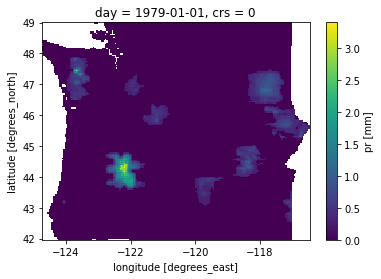

In [10]:
clipped_precip_1979.isel(day=0).plot()

That's looking good ...

Can I save it out?

In [11]:
clipped_precip_1979.to_netcdf('../../data/met/precip/clipped_precip_1979.nc')

ValueError: failed to prevent overwriting existing key grid_mapping in attrs. This is probably an encoding field used by xarray to describe how a variable is serialized. To proceed, remove this key from the variable's attributes manually.

What is this `grid_mapping` I need to get rid of ... is it important?

In [14]:
clipped_precip_1979.attrs['grid_mapping']

'crs'

Huh, I'm not sure why that's there ...

In [15]:
# if I remove it then are other things still okay?
del clipped_precip_1979.attrs['grid_mapping']

In [16]:
clipped_precip_1979.rio.crs

CRS.from_epsg(4326)

So the crs or anything like that isn't gone ... must have been some artifact from when the data was first developed that was overlooked.

In [17]:
clipped_precip_1979.to_netcdf('../../data/met/precip/clipped_precip_1979.nc')

In [18]:
clipped_precip_1979 = xr.open_dataset('../../data/met/precip/clipped_precip_1979.nc')
clipped_precip_1979['precipitation_amount']

<xarray.DataArray 'precipitation_amount' (day: 365, lat: 169, lon: 199)>
[12275315 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 42.11 42.07 42.03 41.98
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -116.6 -116.5 -116.5
  * day      (day) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
Attributes:
    units:              mm
    description:        Daily Accumulated Precipitation
    long_name:          pr
    standard_name:      pr
    dimensions:         lon lat time
    coordinate_system:  WGS84,EPSG:4326
    grid_mapping:       crs

Huh, grid_mapping is back. I'm thinking it must be some auto write-out that just gets in the way of things.

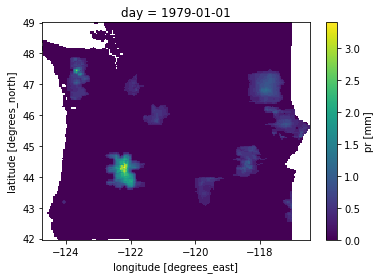

In [19]:
clipped_precip_1979['precipitation_amount'].isel(day=0).plot()

Okay, that saved out alright.

Now let's try merging two years together

In [21]:
# let's repeat 1979 because we know it works
precip_1979 = xr.open_dataset('../../data/met/precip/precip_1979.nc')
precip_1980 = xr.open_dataset('../../data/met/precip/precip_1980.nc')
precip_1981 = xr.open_dataset('../../data/met/precip/precip_1981.nc')

In [22]:
# I don't want to keep typing this, so here
var = 'precipitation_amount'

precip_1979_da = precip_1979[var].rio.write_crs(precip_1979.rio.crs)
precip_1980_da = precip_1980[var].rio.write_crs(precip_1980.rio.crs)
precip_1981_da = precip_1981[var].rio.write_crs(precip_1981.rio.crs)

In [23]:
clipped_precip_1979 = clip_xarray(precip_1979_da, combined_gdf)
clipped_precip_1980 = clip_xarray(precip_1980_da, combined_gdf)
clipped_precip_1981 = clip_xarray(precip_1981_da, combined_gdf)

Will note the clipping still took a bit per each thing, but I think through some clever data management I can make this better than `open_mfdataset` ... which shouldn't be hard given that wasn't working at all before.

In [25]:
clipped_precip_1979_1981 = xr.combine_by_coords([clipped_precip_1979, clipped_precip_1980, clipped_precip_1981])
clipped_precip_1979_1981

<xarray.Dataset>
Dimensions:               (lat: 169, lon: 199, day: 1096)
Coordinates:
  * lat                   (lat) float64 48.98 48.94 48.9 ... 42.07 42.03 41.98
  * lon                   (lon) float64 -124.7 -124.7 -124.6 ... -116.5 -116.5
  * day                   (day) datetime64[ns] 1979-01-01 ... 1981-12-31
    crs                   int64 0
Data variables:
    precipitation_amount  (day, lat, lon) float32 nan nan nan ... nan nan nan

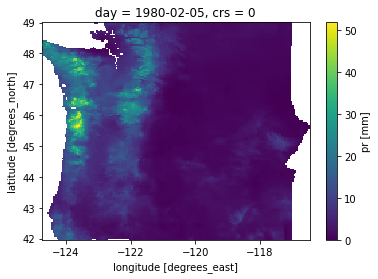

In [29]:
clipped_precip_1979_1981[var].isel(day=400).plot()

That looks successful. Let's try the write out.

In [40]:
if 'grid_mapping' in clipped_precip_1979_1981[var].attrs:
    del clipped_precip_1979_1981[var].attrs['grid_mapping']

clipped_precip_1979_1981.to_netcdf('../../data/met/precip/clipped_precip_1979_1981.nc')

In [43]:
reopen_clipped_precip_1979_1981 = xr.open_dataset('../../data/met/precip/clipped_precip_1979_1981.nc')
reopen_clipped_precip_1979_1981

<xarray.Dataset>
Dimensions:               (lat: 169, lon: 199, day: 1096)
Coordinates:
  * lat                   (lat) float64 48.98 48.94 48.9 ... 42.07 42.03 41.98
  * lon                   (lon) float64 -124.7 -124.7 -124.6 ... -116.5 -116.5
  * day                   (day) datetime64[ns] 1979-01-01 ... 1981-12-31
Data variables:
    crs                   int64 ...
    precipitation_amount  (day, lat, lon) float32 ...

Check equivalency ...

In [45]:
reopen_clipped_precip_1979_1981[var] == clipped_precip_1979_1981[var]

<xarray.DataArray 'precipitation_amount' (day: 1096, lat: 169, lon: 199)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 42.11 42.07 42.03 41.98
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -116.6 -116.5 -116.5
  * day      (day) datetime64[ns] 1979-01-01 1979-01-02 ... 1981-12-31
    crs      int64 0

... is it nan's ...

In [47]:
reopen_clipped_precip_1979_1981[var].values

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [48]:
clipped_precip_1979_1981[var].values

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

Ugh, right. Let's plot it then.

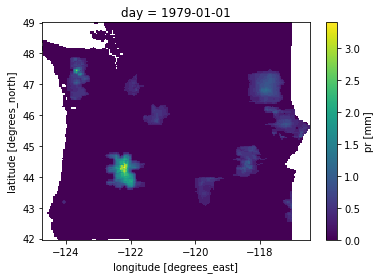

In [49]:
reopen_clipped_precip_1979_1981[var].isel(day=0).plot()

Yeah that saved out fine. It's just fussy.

Onto function writing!

In [90]:
def xarray_clip_combine_years(data_path:str, years, combine_var:str, clip_gdf:gpd.GeoDataFrame):
    """Load, clip, then combine several years of netcdf data.

    This came about as I was looking to combine several years of data that covered all of CONUS,
    but only needed data for Washington and Oregon. I kept using xr.open_mfdataset() but finding
    it struggling with the large amounts of data. So this function instead opens each file 
    individually, clips it to the desired region (using clip_xarray), then combining all
    the data after. Data is unloaded in-between each year to minimize active memory taken up.

    Parameters
    ----------
    data_path : str
        Location of files to be combined. It is expected that the files follow the same naming
        convention, only changing the year at the end so that they can be opened with the string
        f'{data_path}{year}.nc' for each year provided in years. For example, if you wanted to
        combined a bunch of precipitation files called 'precip_1979.nc', 'precip_1980.nc', ... etc.
        then you would provide the path to those files plus 'precip_' at the end of the string.
        It is expected that the netcdf files have spatial dimensions and a crs set that is 
        accessible by rioxarray.
    years : list-like, iterable
        What years to combine the data from. If you wanted to combine all data from 1979 to
        2022 for example, then np.arange(1979, 2023, 1) would satisfy this parameter.
    combine_var : str
       What variable in the netcdf files to combine by. Note this requires all of the files
       you are combining to use the same variable name.
    clip_gdf : gpd.GeoDataFrame
        Contains geometry to clip the netcdf files to and must posses the same crs as the
        netcdf files, otherwise an Exception will be thrown.

    Returns
    -------
    xr.Dataset or list
        Contains data clipped to clip_gdf for all years provided in a single Dataset.
        If a xr.MergeError occurs, then the list of all the clipped data is returned
        instead for manual resolution.
    """
    all_data_list = []
    t = tqdm(years, total=len(years))
    for year in t:
        t.set_description(f'{year}')
        data_ds = xr.open_dataset(f'{data_path}{year}.nc')
        # double check matching CRS
        if data_ds.rio.crs != clip_gdf.crs:
            raise Exception(f'{data_path}{year}.nc does not match the CRS of clip_gdf')
        
        # clip and set crs for dataarray
        data_da = data_ds[combine_var]
        data_da = data_da.rio.write_crs(data_ds.rio.crs)
        clipped_data_da = clip_xarray(data_da, clip_gdf)

        # add it to our list for later combining
        all_data_list.append(clipped_data_da)

        # clean up some of our variables to free up storage
        data_da = None
        data_ds = None
        clipped_data_da = None

    try:
        all_data_ds = xr.combine_by_coords(all_data_list)
        return all_data_ds
    except xr.MergeError:
        print('Merge Error encountered, resolve manually')
        return all_data_list

In [68]:
wa_or_precip = xarray_clip_combine_years('../../data/met/precip/precip_', ['1979', '1980', '1981'], var, combined_gdf)

  0%|          | 0/3 [00:00<?, ?it/s]

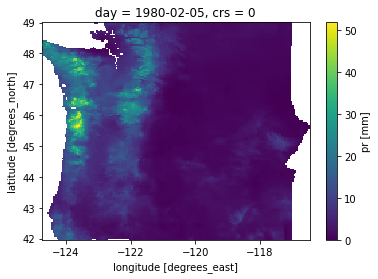

In [70]:
wa_or_precip[var].isel(day=400).plot()

It worked! Now let's do all of the precip and see how that goes.

In [71]:
np.arange(1979, 2023, 1)

array([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [74]:
wa_or_precip = xarray_clip_combine_years('../../data/met/precip/precip_', np.arange(1979, 2023, 1), var, combined_gdf)

  0%|          | 0/44 [00:00<?, ?it/s]

Let's check that each year loaded alright

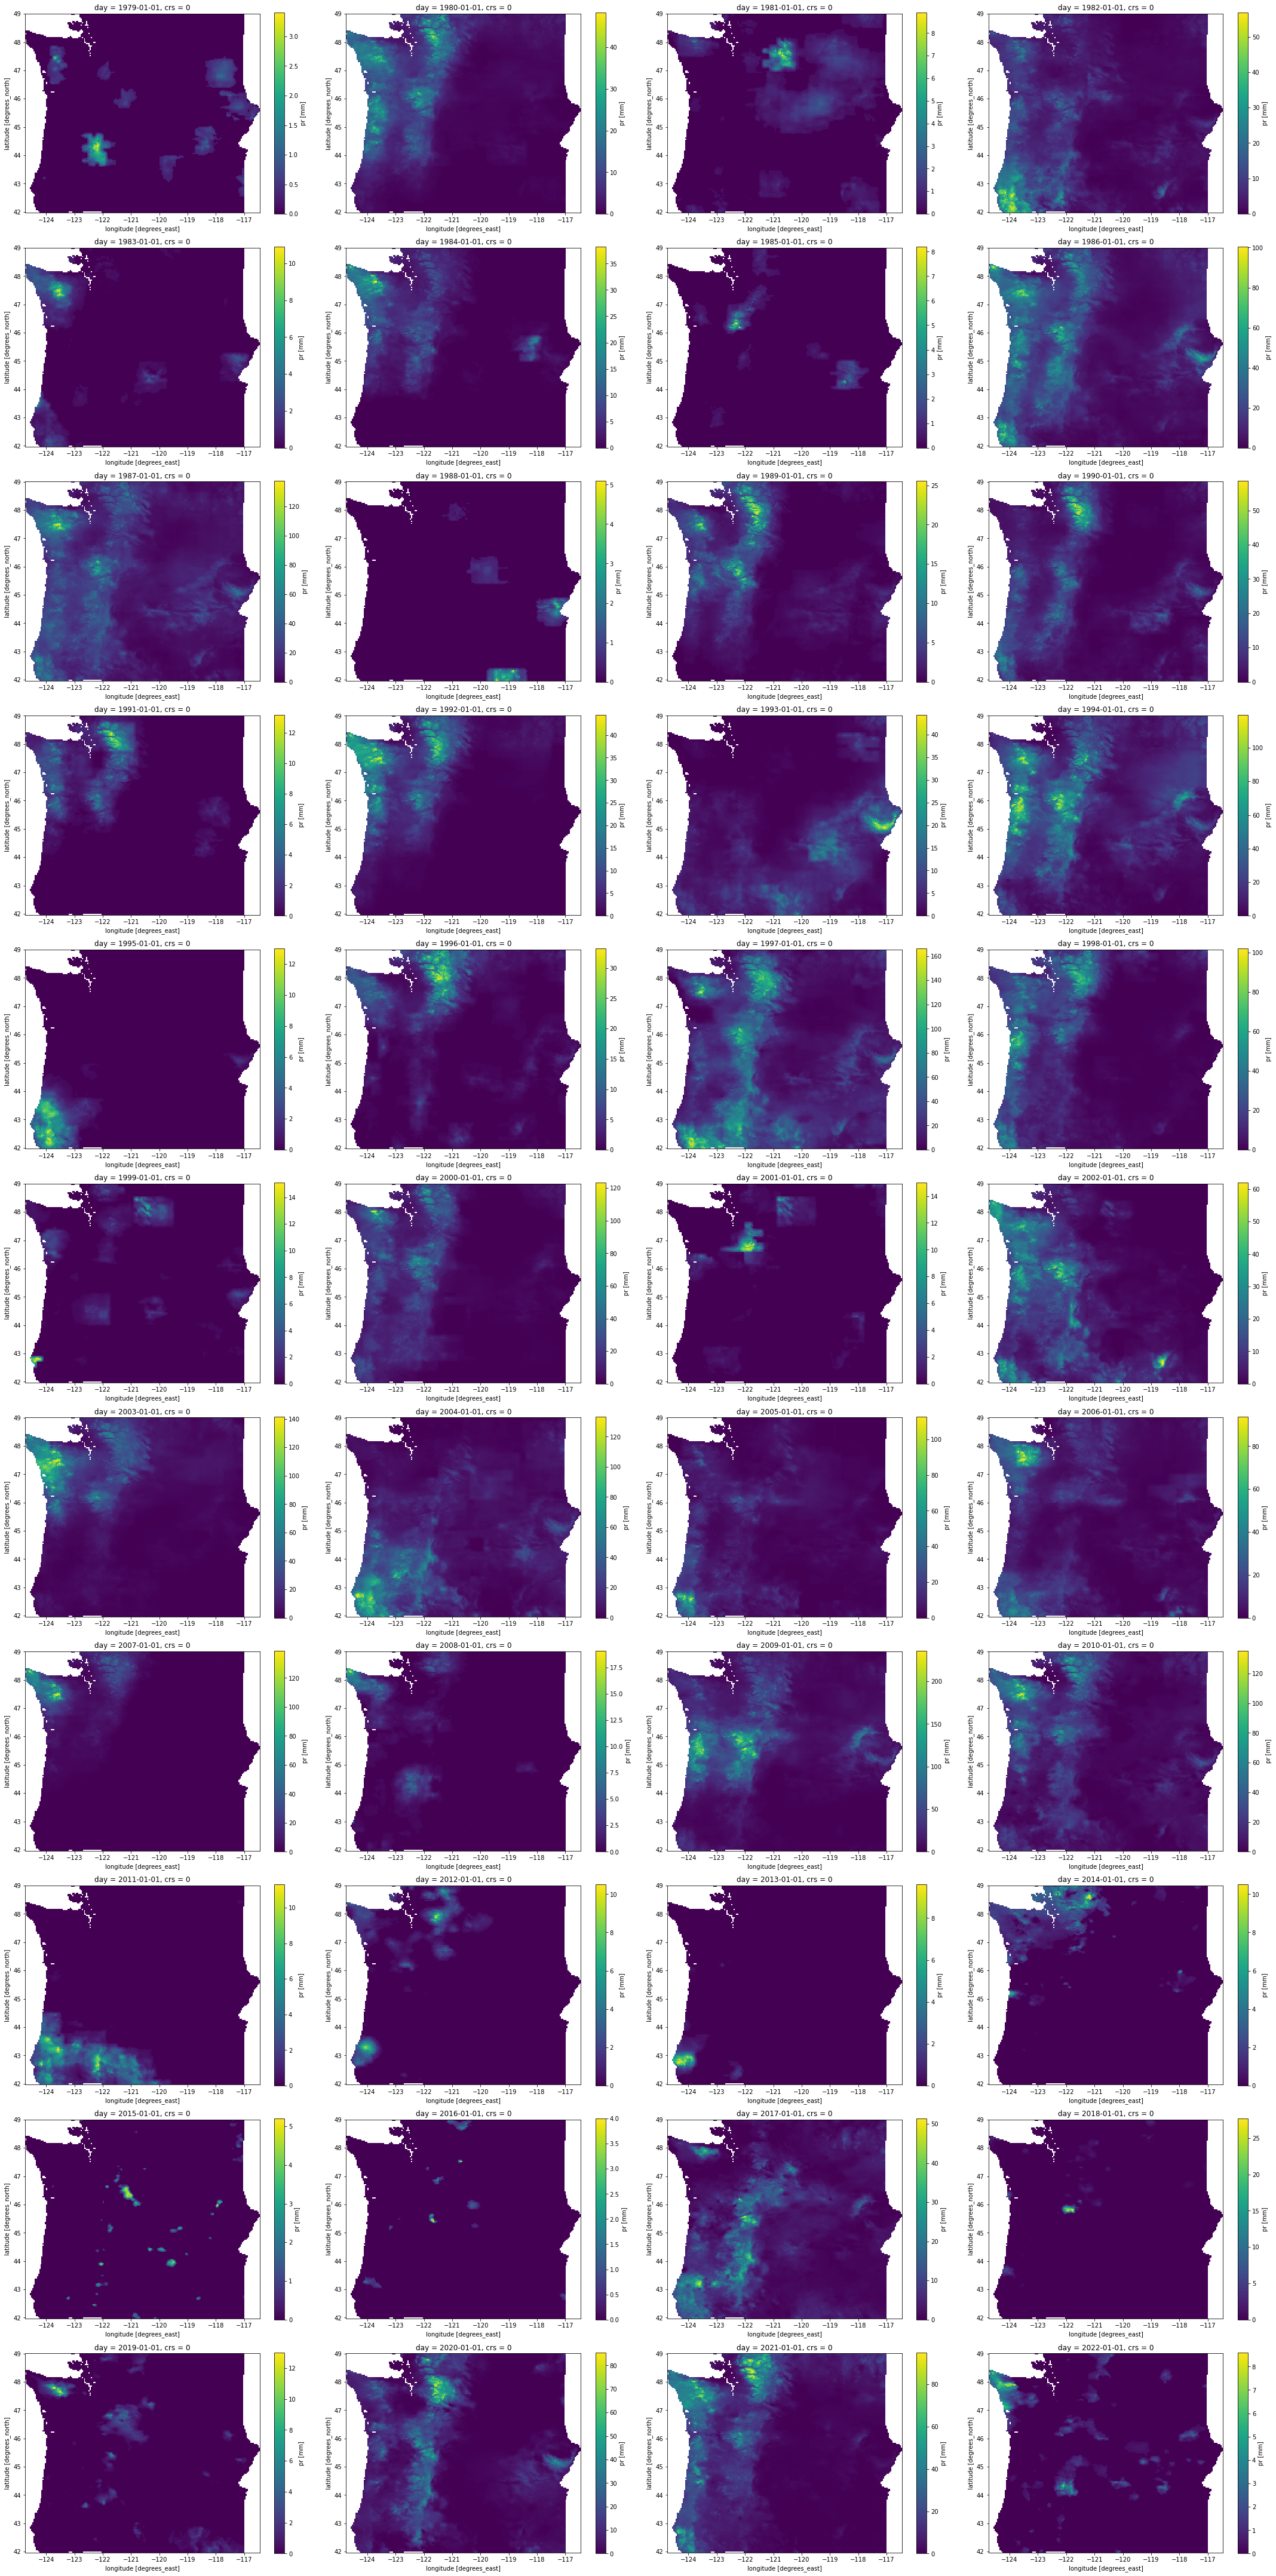

In [81]:
fig, axs = plt.subplots(11, 4, figsize=(30,60))

for ax, year in zip(axs.ravel(), np.arange(1979, 2023, 1)):
    wa_or_precip.sel(day=f'{year}-01-01')[var].plot(ax=ax)
    ax.set_aspect('equal')

plt.tight_layout()

Cool, we got a variety of data. Not sure how useful 2022 will be given it's on-going but yeah.

Check attributes ...

In [85]:
precip_1979[var].attrs

{'units': 'mm',
 'description': 'Daily Accumulated Precipitation',
 'long_name': 'pr',
 'standard_name': 'pr',
 'dimensions': 'lon lat time',
 'grid_mapping': 'crs',
 'coordinate_system': 'WGS84,EPSG:4326'}

In [84]:
wa_or_precip[var].attrs

{'units': 'mm',
 'description': 'Daily Accumulated Precipitation',
 'long_name': 'pr',
 'standard_name': 'pr',
 'dimensions': 'lon lat time',
 'grid_mapping': 'crs',
 'coordinate_system': 'WGS84,EPSG:4326',
 'coordinates': 'lon lat time'}

Yeah will need to toss out that `grid_mapping` again. Also not sure why there is a `coordinates` attribute?

In [87]:
precip_out_path = '../../data/met/precip/wa_or_precip_1979_2022.nc'

try:
    os.remove(precip_out_path)
except:
    pass

if 'coordinates' in wa_or_precip[var].attrs:
    del wa_or_precip[var].attrs['coordinates']
if 'grid_mapping' in wa_or_precip[var].attrs:
    del wa_or_precip[var].attrs['grid_mapping']

wa_or_precip.to_netcdf(precip_out_path)

That worked! 

Going to jot down some documentation then move on to doing that for the other variables.

I might clip down the data more based on different parks and such, but now I have 1 file to open that is cumulatively smaller to open than all the years alone :)

In [88]:
xr.open_dataset('../../data/met/tair_max/tair_max_1979.nc')

<xarray.Dataset>
Dimensions:          (lon: 1386, lat: 585, day: 365, crs: 1)
Coordinates:
  * lon              (lon) float64 -124.8 -124.7 -124.7 ... -67.14 -67.1 -67.06
  * lat              (lat) float64 49.4 49.36 49.32 49.28 ... 25.15 25.11 25.07
  * day              (day) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
  * crs              (crs) uint16 3
Data variables:
    air_temperature  (day, lat, lon) float32 ...
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       02 July 2019
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [91]:
var = 'air_temperature'
wa_or_tair_max = xarray_clip_combine_years('../../data/met/tair_max/tair_max_', np.arange(1979, 2023, 1), var, combined_gdf)

  0%|          | 0/44 [00:00<?, ?it/s]

Merge Error encountered, resolve manually


In [97]:
xr.combine_by_coords(wa_or_tair_max)

MergeError: combine_attrs='no_conflicts', but some values are not the same. Merging {'units': 'K', 'description': 'Daily Maximum Temperature', 'long_name': 'tmmx', 'standard_name': 'tmmx', 'dimensions': 'lon lat time', 'grid_mapping': 'crs', 'coordinate_system': 'WGS84,EPSG:4326'} with {'units': 'K', 'description': 'Daily Maximum Temperature (2m)', 'long_name': 'tmmx', 'standard_name': 'tmmx', 'dimensions': 'lon lat time', 'grid_mapping': 'crs', 'coordinate_system': 'WGS84,EPSG:4326', 'coordinates': 'lon lat time'}

In [95]:
wa_or_tair_max_conflict_drop = xr.combine_by_coords(wa_or_tair_max, combine_attrs='drop_conflicts')
wa_or_tair_max_conflict_drop

<xarray.Dataset>
Dimensions:          (lat: 169, lon: 199, day: 15767)
Coordinates:
  * lat              (lat) float64 48.98 48.94 48.9 48.86 ... 42.07 42.03 41.98
  * lon              (lon) float64 -124.7 -124.7 -124.6 ... -116.6 -116.5 -116.5
  * day              (day) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-03-02
    crs              int64 0
Data variables:
    air_temperature  (day, lat, lon) float32 nan nan nan nan ... nan nan nan nan

In [98]:
wa_or_tair_max_conflict_drop[var].attrs

{'units': 'K',
 'long_name': 'tmmx',
 'standard_name': 'tmmx',
 'dimensions': 'lon lat time',
 'grid_mapping': 'crs',
 'coordinate_system': 'WGS84,EPSG:4326',
 'coordinates': 'lon lat time'}

I'm fine with this.

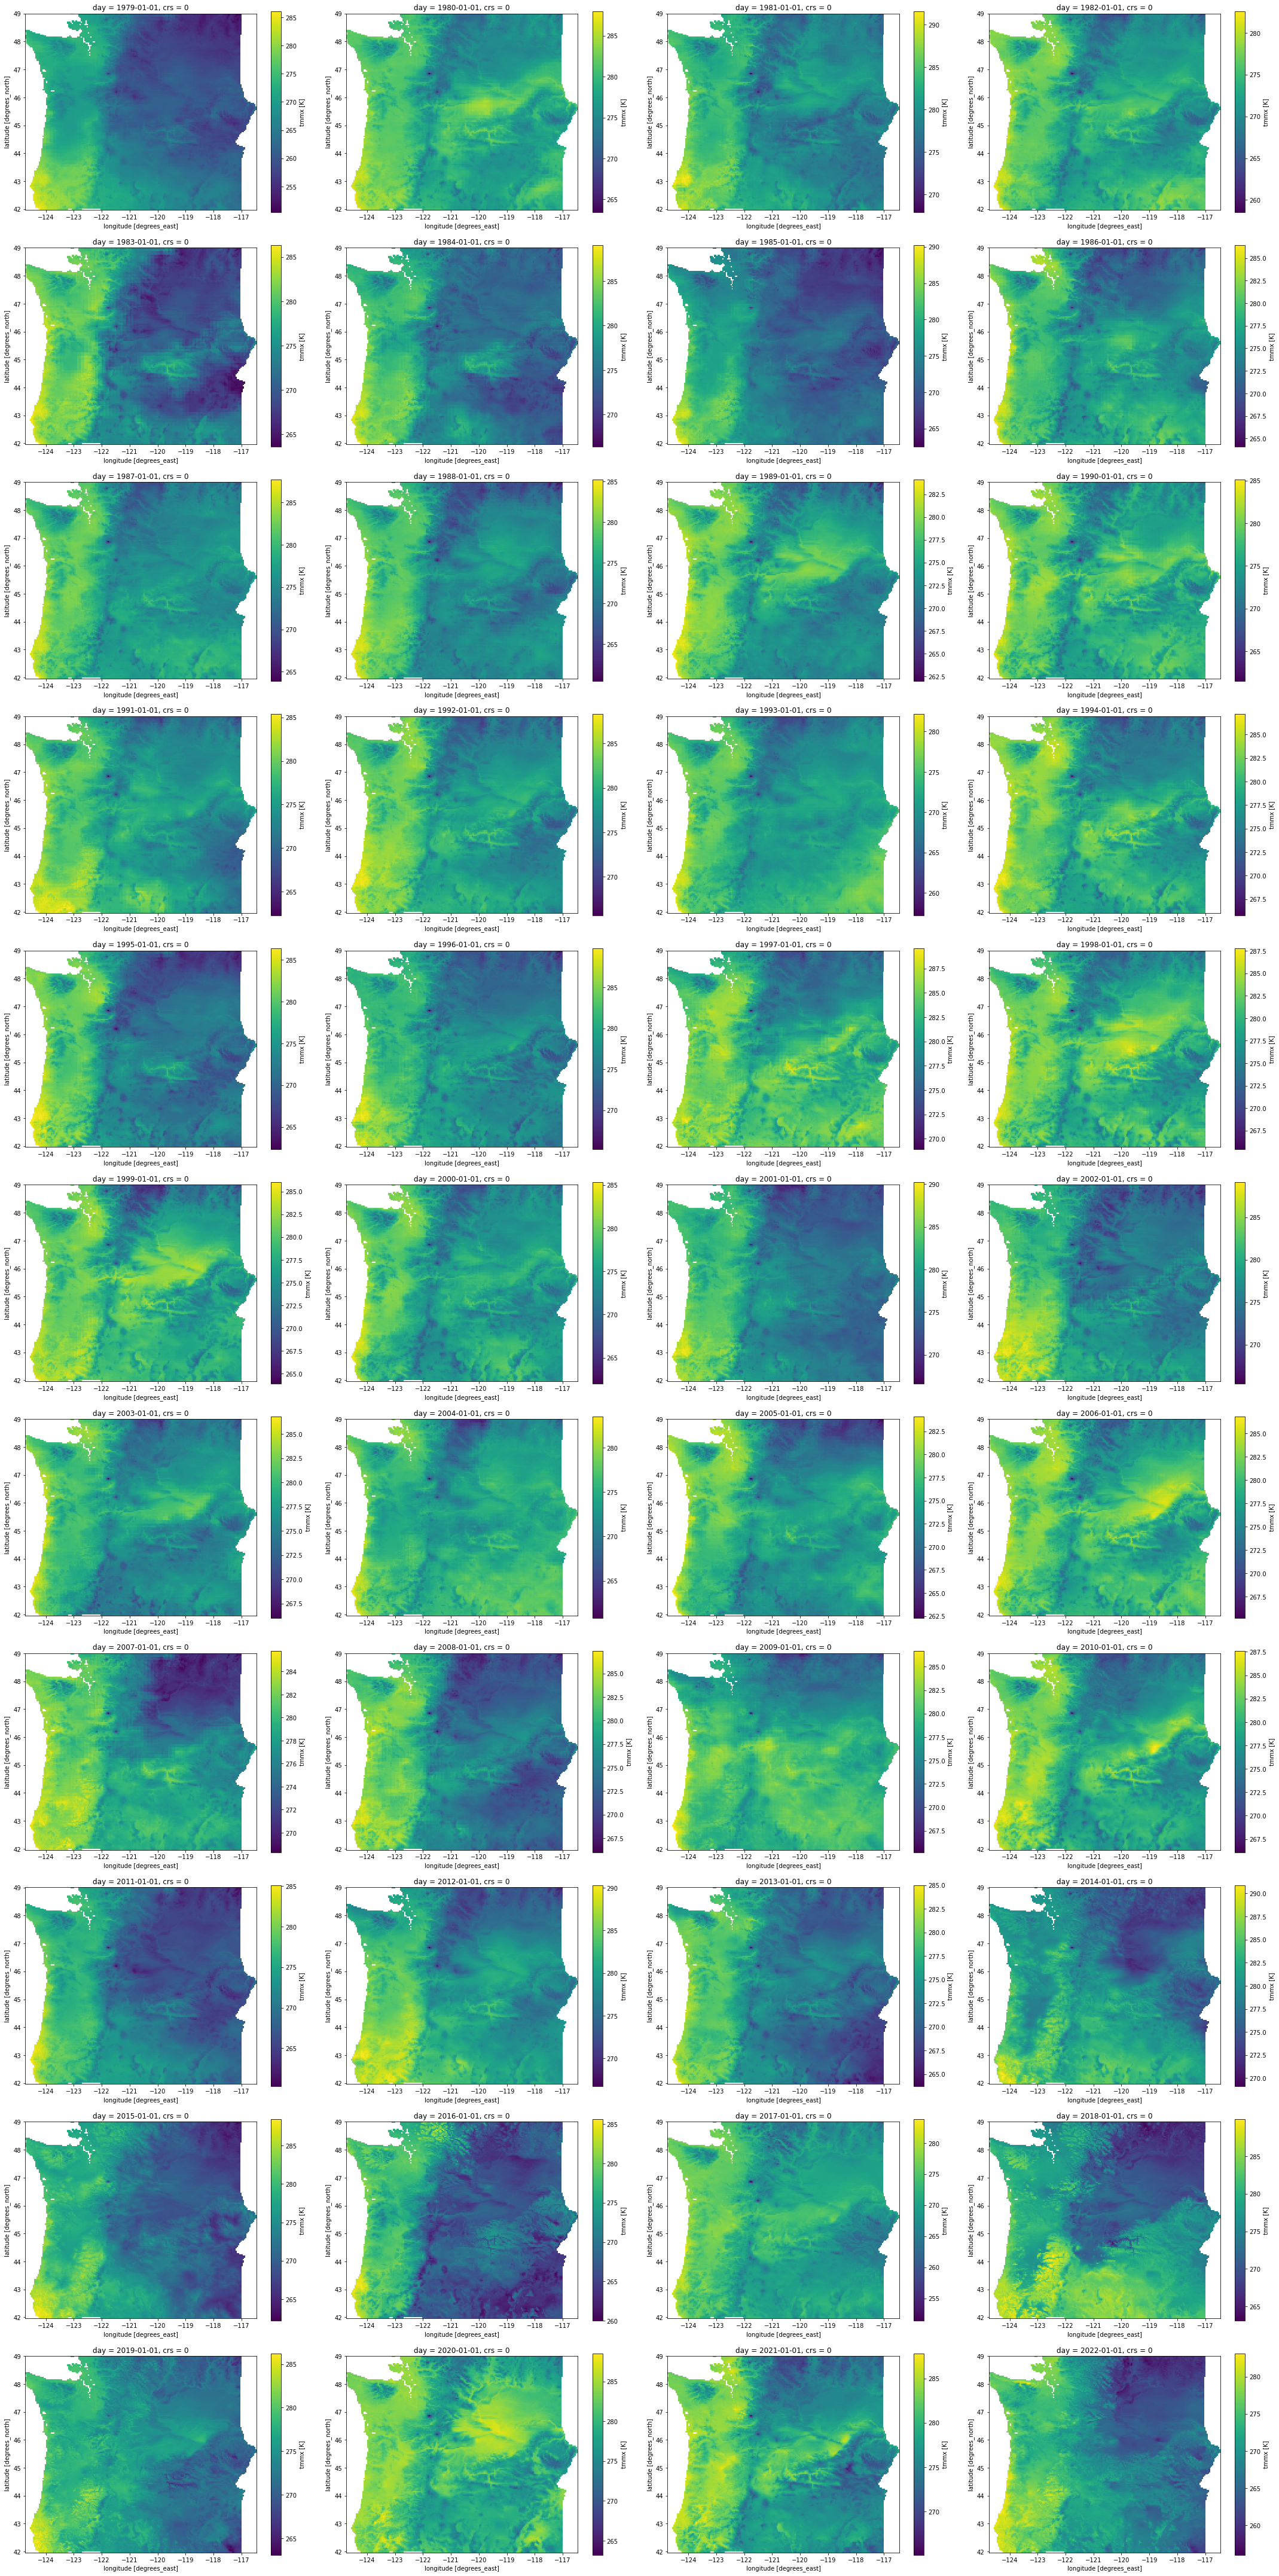

In [99]:
fig, axs = plt.subplots(11, 4, figsize=(30,60))

for ax, year in zip(axs.ravel(), np.arange(1979, 2023, 1)):
    wa_or_tair_max_conflict_drop.sel(day=f'{year}-01-01')[var].plot(ax=ax)
    ax.set_aspect('equal')

plt.tight_layout()

Looks like temperatures to me.

In [111]:
tmax_out_path = '../../data/met/tair_max/wa_or_tair_max_1979_2022.nc'

try:
    os.remove(tmax_out_path)
except:
    pass

if 'coordinates' in wa_or_tair_max_conflict_drop[var].attrs:
    del wa_or_tair_max_conflict_drop[var].attrs['coordinates']
if 'grid_mapping' in wa_or_tair_max_conflict_drop[var].attrs:
    del wa_or_tair_max_conflict_drop[var].attrs['grid_mapping']

wa_or_tair_max_conflict_drop.to_netcdf(tmax_out_path)

In [102]:
xr.open_dataset('../../data/met/tair_min/tair_min_1979.nc')

<xarray.Dataset>
Dimensions:          (lon: 1386, lat: 585, day: 365, crs: 1)
Coordinates:
  * lon              (lon) float64 -124.8 -124.7 -124.7 ... -67.14 -67.1 -67.06
  * lat              (lat) float64 49.4 49.36 49.32 49.28 ... 25.15 25.11 25.07
  * day              (day) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
  * crs              (crs) uint16 3
Data variables:
    air_temperature  (day, lat, lon) float32 ...
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       02 July 2019
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [105]:
var = 'air_temperature'
wa_or_tair_min = xarray_clip_combine_years('../../data/met/tair_min/tair_min_', np.arange(1979, 2023, 1), var, combined_gdf)

  0%|          | 0/44 [00:00<?, ?it/s]

Merge Error encountered, resolve manually


In [106]:
xr.combine_by_coords(wa_or_tair_min)

MergeError: combine_attrs='no_conflicts', but some values are not the same. Merging {'units': 'K', 'description': 'Daily Minimum Temperature', 'long_name': 'tmmn', 'standard_name': 'tmmn', 'dimensions': 'lon lat time', 'grid_mapping': 'crs', 'coordinate_system': 'WGS84,EPSG:4326'} with {'units': 'K', 'description': 'Daily Minimum Temperature (2m)', 'long_name': 'tmmn', 'standard_name': 'tmmn', 'dimensions': 'lon lat time', 'grid_mapping': 'crs', 'coordinate_system': 'WGS84,EPSG:4326', 'coordinates': 'lon lat time'}

This looks like the same thing earlier with max temp

In [109]:
wa_or_tair_min_conflict_drop = xr.combine_by_coords(wa_or_tair_min, combine_attrs='drop_conflicts')
wa_or_tair_min_conflict_drop[var].attrs

{'units': 'K',
 'long_name': 'tmmn',
 'standard_name': 'tmmn',
 'dimensions': 'lon lat time',
 'grid_mapping': 'crs',
 'coordinate_system': 'WGS84,EPSG:4326',
 'coordinates': 'lon lat time'}

In [112]:
tmin_out_path = '../../data/met/tair_min/wa_or_tair_min_1979_2022.nc'

try:
    os.remove(tmin_out_path)
except:
    pass

if 'coordinates' in wa_or_tair_min_conflict_drop[var].attrs:
    del wa_or_tair_min_conflict_drop[var].attrs['coordinates']
if 'grid_mapping' in wa_or_tair_min_conflict_drop[var].attrs:
    del wa_or_tair_min_conflict_drop[var].attrs['grid_mapping']

wa_or_tair_min_conflict_drop.to_netcdf(tmin_out_path)

Tha's going to be enough to get going for now